# Library

In [1]:
import time
import datetime
from datetime import datetime, timedelta

import re
import gc

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

import random 
from random import sample

rus_mon_dict = {'янв': '01', 'фев': '02', 'мар': '03',
                'апр': '04', 'мая': '05', 'июн': '06',
                'июл': '07', 'авг': '08', 'сен': '09',
                'окт': '10', 'ноя': '11', 'дек': '12'}

## Folders & Files

In [2]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

# files
page_s = '/page_parsing_status.csv'

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
artinvest_lt = '/artinvest_long_text.csv'
artinvest_w = '/artinvest_with_long_text.csv'

theartnewspaper_d = '/theartnewspaper_data_new.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'
theartnewspaper_w = '/theartnewspaper_with_long_text.csv'

artchive_s = '/artchive_pages_counter_stat.csv'
artchive_d = '/artchive_news_articles_data.csv'
artchive_lt = '/artchive_long_text.csv'
artchive_w = '/artchive_with_long_text.csv'

artuzel_s = '/artusel_pages_counter_stat.csv'
artuzel_d = '/artuzel_news_articles_data.csv'
artuzel_lt = '/artuzel_long_text.csv'
artuzel_w = '/artuzel_with_long_text.csv'

## Sites' list for parsing

In [3]:
urls_news = ['https://www.theartnewspaper.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/', 'https://artchive.ru/'] # 'https://artguide.com/', 'http://artuzel.com/', 
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/']
urls_archives = ['https://artchive.ru/', 'https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

In [4]:
# topping up dict (manually yet)
#                             site,       s_file,        d_file,        lt_file
df_dict = {'https://www.theartnewspaper.ru/': ['-', theartnewspaper_d, theartnewspaper_lt], 
           'https://artinvestment.ru/': [artinvest_s, artinvest_d, artinvest_lt],
           'https://artchive.ru/': [artchive_s, artchive_d, artchive_lt],
           'https://artuzel.com/': [artuzel_s, artuzel_d, artuzel_lt]
           }

# Unused code

In [ ]:
# drop part of df
#artinvest_news_articles_data = artinvest_news_articles_data.drop(artinvest_news_articles_data[artinvest_news_articles_data['page_url']=='20220209_Hirst.html'].index)

In [ ]:
# delete all data from df
#artinvest_news_articles_data = artinvest_news_articles_data[0:0]
#theartnewspaper_data = theartnewspaper_data[0:0]

In [ ]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Functions

## Openings and savings
1. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
2. __open_file_csv(file, folder)__ -> df - Open file.csv
3. __save_df_file(df, file, folder)__ -> - Save df to csv file
4. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
5. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp
6. __date_transfomation(cell)__ -> cell - Date transfomation

In [5]:
# 1. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 2. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 3. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)

# 4. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 5. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

In [6]:
# 6. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Text transformations
7. **get_cat(df)** -> df - Getting category: news or articles

In [7]:
# 7. Getting category: news or articles
def get_cat(df):
  sites = open_parsing_dict() # 1. Open dict with sites for parsing
  news_cat_list = []
  for k1, v1 in sites.items():
    for k2, v2 in v1.items():
      if k2=='news':
        for k3, v3 in v2.items():
          if k3=='links':
            for link in v3:
              news_cat_list.append(link)

  df['news_article_cat'] = df['page_url'].dropna().apply(lambda x: 'news' if x in news_cat_list else 'articles')
  return df

### Text cleaning step 1

In [8]:
# 8. Text cleaning step 1 - remove invisible blanks, put blanks where it's needed

# move = dict.fromkeys((ord(c) for c in r'\xa0\n\t\u200d')) # don't replace on ' '

def replace_func(text): # goes before split !!!
#remove invisible blanks
  text = re.sub(r'\\n|\\r|\\tc|\\t|\\xa0|\\xad|\n|\r|\tc|\t|\xa0|\xad', ' ', text).replace(r'\\+', '').strip()
  text = text.replace(u'\\u200b', '').replace(u'\\u200e', '').replace(u'\u200b', '').replace(u'\u200e', '').replace(u'\\u2009', '').replace(u'\u2009', '').replace(u'\\u2028', '').replace(u'\u2028', '').replace(u'\\u2002', '').replace(u'\u2002', '').strip() # ' ' - ?? - no
  text = re.sub(r'\\\\\\', '', text) # (\\\ ) - check + #(\\)(\\)(\\)
  text = re.sub(r'\",\s\'', ' ', text) # (", ') - check + #(\")(,\s)(\')
  text = re.sub(r'\',\s\"', ' ', text) # (', ") - check + #(\')(,\s)(\")
  #text = re.sub(r'\",\s\"', ' ', text) # (", ") - artchive - ??
#put blanks where it's needed
  text = re.sub(r'(\s+)(\.)', r'\2', text) # Винсент ушел . - check - use strip() then !!!
  text = re.sub(r'(\.)([A-ZА-Я])([A-ZА-Яa-zа-я\s])', '. '+r'\2\3', text) # -> # ГМИИ им. А. С. Пушкина # S. M. A. K. - check +
  text = re.sub(r'(\.)([0-9]{1,2})(\s)', '. '+r'\2\3', text) # Синезубова.3 февраля # (Нью-Дели).27 мая - check +
  #text = re.sub(r'([^\.«-(\'\"])([A-ZА-Я])', r'\1'+' '+r'\2', text) # 1954Впервые # МоскваРаботы # (Арсенал)Выставка -> ГМ ИИ им. А.С. Пушкина # XV II I
  text = re.sub(r'([a-zа-я0-9)])([A-ZА-Я])', r'\1'+' '+r'\2', text) # 1954Впервые # МоскваРаботы # (Арсенал)Выставка -> Mac Dougall’s # «Му ХА» # Mo MA - check !
  text = re.sub(r'([^(\'\"])([«])', r'\1'+' '+r'\2', text) # правительство.«Портрет Валли» - check +
  text = re.sub(r'([»"])([^\.,?!:;)\'\"])', r'\1'+' '+r'\2', text) # Баженовой»11 - check + "-?
  text = re.sub(r'([A-ZА-Яa-zа-я0-9])(w{3}\.)', r'\1'+' '+r'\2', text) # 2 июняwww.palazzorealemilano.it. - chec
  text = re.sub(r'([0-9]+)(\s+)([0-9]+)', r'\1\3', text) # .RU 14 апреля 2021. vs .RU 2 3 июня 2014. # 19 30–1970-е # 3 31-е vs 30 000 руб - check - 14600 000 рублей ??
  # doesn't work from the first time
  text = re.sub(r'<!--.*-->\.', '', text) #(<!--)(.*)(-->\.)# <!-- .style7 {font-size: 7pt } .ne w {cursor: pointer; cursor: hand } -->. - check ??
  return text

# 19.30-21. 00 vs 19.30-21.00.
# ( Aya Maria Urhammer , Mariella Ottosson)

def split_func(text): # в коллекциях. Олега. Кулика. 
  end_list = ['.', '?', '!', ',', ':', ';']
  if len(text[2:-2].split("', '")) > 0:
    texts_list = text[2:-2].split("', '")
    texts_list_new = [sent.strip() + '.' if len(sent.strip())>0 and sent.strip()[-1] not in end_list else sent.strip() for sent in texts_list]
    #text = ' '.join(texts_list_new)
  else:
    texts_list = text[2:-2].split('", "')
    texts_list_new = [sent.strip() + '.' if len(sent.strip())>0 and sent.strip()[-1] not in end_list else sent.strip() for sent in texts_list]
    #text = ' '.join(texts_list_new)

  #return text
  return texts_list_new # !!!!!!!!!!!!


def clean_text_1(df):
  for col in ['long_text', 'structure']:
    df[col] = df[col].dropna().apply(lambda x: ' '.join(replace_func(x).split()))
    ##df[col] = df[col].dropna().apply(lambda x: ' '.join(split_func(x).split())) # !!! -> split_func()
    #df[col] = df[col].dropna().apply(lambda x: split_func(x)) # !!! -> split_func()
    df[col] = df[col].dropna().apply(split_func)
  for col in ['short_text', 'title']:
    df[col] = df[col].dropna().apply(lambda x: ' '.join(replace_func(x).split()))

  return df

### Text cleaning step 2

In [9]:
# 9. Text cleaning step 2 - extra patterns removing

#theartnewspaper_w_text - long_text
  #Подписаться на новости. #Материалы по теме: ... # !!! tags in between !!!
  #... Свежий номер The Art Newspaper Russia можно купить здесь.
  #№98 Материал из газеты ...
  #The Art Newspaper Russia 03.09.2015. #Ада Мазоэро 03.09.2015. #Хилари М. Шитс 19.01.2022. #Клео Робертс -Комиредди 28.01.2022.

def pattern_func_tanp(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    text = re.sub('Подписаться на новости.', '', text) # - check +
    text = re.sub('Материалы по теме: ', '', text) # - check +
    text = re.sub('Свежий номер The Art Newspaper Russia можно купить здесь.', '', text) # - check + in all 3 samples the same pattern
    text = re.sub(r'№[0-9]+\sМатериал\sиз\sгазеты\s', '', text) # - check + !!!!!!
    text = re.sub(r'<!--.*-->\.', '', text) # !!!!!!!! <!-- .style7 {font-size: 7pt } .ne w {cursor: pointer; cursor: hand } -->. - check ??
    if ind == 1:
      text = re.sub(r'(?:\s*)(?:The\sArt\sNewspaper\sRussia\s\d{2}\.\d{2}\.\d{4}\.)$', '.', text, flags=re.MULTILINE)
      text = re.sub(r'(?:\s*)(?:[А-ЯA-Z][а-яa-z]+\s)(?:[А-ЯA-Z]\.\s|[А-ЯA-Z][а-яa-z]+\s*-*\s*){0,1}(?:[А-ЯA-Z][а-яa-z]+\s\d{2}\.\d{2}\.\d{4}\.)$', '.', text, flags=re.MULTILINE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)
  
  return text_list_new


# artuzel_news_articles_w_text
  #dubbles in strings but can be signs of images
  #blank strings

  #Над интервью работала … #Интервью подготовили … 
  #Интервью: … #Видеоверсия интервью:
  #Фотограф: … #Фото: … фото: … #Текст: … текст: … #Текст и фото: … #Источники: #Авторы: … Автор: … #Перевод: 
  #Материал подготовила … #Фото предоставлены …

def pattern_func_artuz(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind > 0:
      if text == text_list[ind-1]: #dubbles in strings but can be signs of images
        text = ''

    text = re.sub(r'^(?:Над\s){0,1}(?:[Ии]нтервью\s)(?:работал|подготовил)(?:.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:Видеоверсия\s){0,1}(?:[Ии]нтервью:)(?:.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:[Фф]ото|[Тт]екст|[Ии]сточник|[Аа]втор|[Пп]еревод)(?:граф|\sи\sфото|и|ы|ка){0,1}(?::.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:Материал|Фото)(?:\s)(?:подготов|предостав)(?:.+)', '', text, flags=re.MULTILINE) # +
    
    if len(text) > 0: #blank strings
      text_list_new.append(text)

  return text_list_new

  #Место проведения: -> no info #Даты: -> no info #Художники: -> no info #Организаторы: -> no info #names: -> no info
  #initials (with blank space or without) -> no info

def pattern_func_artuz_struct(text_list):
  text_list_new = []

  for text in text_list:
    text = text.strip()
    try:
      if len(text) < 25 and re.search(r':$', text, flags=re.MULTILINE)[0]==':':
      #if len(text) < 25 and re.search(r':$', text, flags=re.MULTILINE):
        text = ''
    except: pass

    text = re.sub(r'^(?:[A-ZА-Я]\.)(?:\s){0,1}(?:[A-ZА-Я]){0,1}(?:\.){0,1}(?:[:]){0,1}$', '', text, flags=re.MULTILINE) # - check +
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


#artchive_news_articles_w_text
  #Артхив: читайте нас в Телеграме и смотрите в Инстаграме (with . or not) …
  #Телеграме. #Инстаграме. #Facebook. #Instagram. #Здесь. здесь.
  # 1. # 10. - !!!!! - if text.isdigit()==True
  #Читать дальше global.move_popup_to_body(\'#id_popup_dotted_more_phg Gd BOfh RSJ\');

def pattern_func_artch(text_list):
  patterns_list = ['Телеграме.', 'Инстаграме.', 'Facebook.', 'Instagram.', 'Здесь.']
  text_list_new = []

  for text in text_list:
    text = text.strip()
    text = re.sub(r'(?:Артхив: читайте нас в Телеграме и смотрите в Инстаграме)(?:\.*)', '', text)
    text = re.sub(r'Читать дальше global.move_popup_to_body(.*);\s*', '', text)
    text = re.sub(r'^(?:\d+\.)$', '', text, flags=re.MULTILINE) # - check ?
    
    for pattern in patterns_list:
      if len(text)==len(pattern):
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


#repeated sentences inside the string in 'Аналитика'

def dubbles_artch(text_list): # works but not always !!!! leave till nlp !!!
  punct_list = ['.', '?', '!']
  text_list_new = []

  for text in text_list:
    text = text.strip()
    text_new = []

    while len(text.split('. ')) > 1: # except the first line - shouldn't be a pattern
      text_split = text.split('. ')
      #if len(text_split[-1])>0 and
      pattern = text_split[-1][:-1] if text_split[-1][-1] in punct_list else text_split[-1] # the last line
      
      if text_split[-1] not in text_new: # can't use set
        text_new.append(text_split[-1]) # last lines list, then reverse it

      # except the last line which is the pattern
      text_split_new = [t.replace(pattern, '').strip() for t in text_split[:-1] if len(t.replace(pattern, '').strip())>0]
      text = '. '.join(text_split_new)

    text_new.append(text) # add the first line
    text_new.reverse()

    if len(text_list_new)==0: # list with lists !
      text_list_new.append(text_new)
      text_list_set = list(set(text_new))
    else:
      text_list_new.append([t for t in text_new if t in list(set(text_new) - set(text_list_set))])
      text_list_set = list(set(text_list_set + text_new))

  #text_list_new_new = [t for t in text for text in text_list_new]
  text_list_new_new = []
  for text in text_list_new:
    for t in text:
      text_list_new_new.append(t)

  return text_list_new_new


#artinvest_news_articles_w_text
  #<!-- .style7 {font-size: 7pt} .new {cursor: pointer; cursor: hand} -->.
  #td.style7 {font-size: 8pt; background:#ffffff;}.
  #… ARTinvestment.RU 14 сентября 2021.
  #Материал подготовила … Беседу вела … Вопросы задавала … Смотрите фоторепортаж с открытия выставки ...
  #Данный материал в оригинале вы можете посмотреть здесь.
  #Источники. … Источники: … Источник. … Источник: …
  #Редакция ARTinvestment.RU.
  #Денис Белькевич, AI. #Алексей Смирнов, специально для AI. #Перевод и адаптация — Денис Белькевич, AI.

def pattern_func_artinvest(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind == 0:
      text = re.sub(r'(?:\sARTinvestment\.\s{0,1}RU\s\d{1,2}\s[а-я]+\s\d{4})(?:[\s\.]*)', '. ', text) # - check +?
    
    text = re.sub(r'<!--.*-->\.', '', text) # - check +
    text = re.sub(r'td\.style.*{.*}\.', '', text) # - check +
    text = re.sub(r'(?:Редакция ARTinvestment\.RU|Данный материал в оригинале вы можете посмотреть здесь)(?:\.*)', '', text) # - check +
    
    text = re.sub(r'^(?:Материал подготовил|Беседу вел|Интервью провел|Вопросы задавал|Беседовал|Смотрите фоторепортаж с открытия выставки)(?:.*)', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:Источник)(?:и){0,1}(?:[:\.])(?:.*)', '', text, flags=re.MULTILINE) # - check +

    text = re.sub(r'(?:Перевод\sи\sадаптация\s—\s){0,1}(?:[А-ЯA-Z][а-яa-z]+)(?:\s[А-ЯA-Z][а-яa-z]+)(?:,\s)(?:специально\sдля\s){0,1}(?:AI)(?:\.*)', '', text) # - check +?
    text = re.sub(r'^(?:Комментарий\s){0,1}(?:AI\.)$', '', text, flags=re.MULTILINE) # - check +?

    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)
  
  return text_list_new


  #Д.К. #А.Д.: #Г. Ч.: #Э.:
  #1. #2. #... #10. #... #Часть 1. #Подробнее о лоте 8.
  #2,194. #↗.
  #здесь. #[email protected]. #ARTinvestment.RU.
  #artinvestment.ru.

def pattern_func_artinvest_struct(text_list):
  text_list_new = []
  
  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind > 0:
      if text == text_list[ind-1]: #dubbles in strings but can be signs of images
        text = ''

    if text.isdigit()==True:
      text = ''

    text = re.sub(r'^(?:[A-ZА-Я]\.)(?:\s){0,1}(?:[A-ZА-Я]){0,1}(?:\.){0,1}(?:[:]){0,1}$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:Часть\s|Подробнее\sо\sлоте\s){0,1}(?:\d+\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:\d+)(?:[,\s]\d+){1,}(?:\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:[↗↘]*\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:\[email protected\])(?:.*)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:ARTinvestment\.RU|здесь|Комментарий редактора|Правила приема работ на аукцион AI можно посмотреть здесь)(?:\.*)$', '', text, flags=re.MULTILINE) # - check 
    text = re.sub(r'^(?:artinvestment\.ru)(?:.*)$', '', text, flags=re.MULTILINE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


def clean_text_2(df, name):
  if name=='tanp':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_tanp(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_tanp)
  elif name=='artuz':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artuz(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artuz)
    #df['structure'] = df['structure'].dropna().apply(lambda x: pattern_func_artuz_struct(pattern_func_artuz(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artuz).apply(pattern_func_artuz_struct)
  elif name=='artch':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artch(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artch)
    #df['structure'] = df['structure'].dropna().apply(lambda x: dubbles_artch(pattern_func_artch(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artch).apply(dubbles_artch)
  elif name=='artinvest':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artinvest(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artinvest)
    #df['structure'] = df['structure'].dropna().apply(lambda x: pattern_func_artinvest_struct(pattern_func_artinvest(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artinvest).apply(pattern_func_artinvest_struct)
  
  return df

### Tags cleaning

In [10]:
# 10. Tags cleaning

def replace_func_short(text): # goes before split !!!
  text = re.sub(r'\\n|\\r|\\tc|\\t|\\xa0|\\xad|\n|\r|\tc|\t|\xa0|\xad', ' ', text).strip()
  text.replace(u'\\u200b', ' ').replace(u'\\u200e', ' ').replace(u'\u200b', ' ').replace(u'\u200e', ' ').replace(u'\\u2009', ' ').replace(u'\u2009', ' ').replace(u'\\u2028', ' ').replace(u'\u2028', ' ').replace(u'\\u2002', ' ').replace(u'\u2002', ' ').strip()
  text = text.replace('#', '').lower()
  text = re.sub(r'\\\\\\', '', text) # (\\\ )
  text = re.sub(r'\",\s\'', ' ', text) # (", ')
  text = re.sub(r'\',\s\"', ' ', text) # (', ")
  text = re.sub(r'\",\s\"', ' ', text) # (", ")
  
  return text


def split_func_short(text):
  if len(text[2:-2].split("', '")) > 0:
    texts_list = text[2:-2].split("', '")
  else:
    texts_list = text[2:-2].split('", "')
    
  texts_list_new = [text for text in texts_list if len(text)>0]

  return texts_list_new

# find_pattern

In [ ]:
def find_pattern(cell, pattern):
  for line in cell:
    try:
      if re.search(pattern, line)[0]==pattern:
        cell = 1
        break
    except:
      cell = 0

  return cell

df['pattern'] = df['structure'].dropna().apply(lambda x: find_pattern(x, 'Свежий номер:'))

index_list = df.loc[(df['page_title']=='Новости')&(df['pattern']==1)].index.tolist()
len(index_list)

#sample_df = df.iloc[index_list]

3

# Preprocessing

## first time

In [19]:
# Opening first time - !!!!!!!!!!!!!!
start_t = time.time()

artinvest_news_articles_data = open_file_csv(artinvest_d, 'live') # 2. Open file.csv
artinvest_long_text_df = open_file_csv(artinvest_lt, 'live') # 2. Open file.csv

theartnewspaper_data = open_file_csv(theartnewspaper_d, 'live') # 2. Open file.csv
theartnewspaper_long_text_df = open_file_csv(theartnewspaper_lt, 'live') # 2. Open file.csv

artchive_news_articles_data = open_file_csv(artchive_d, 'live') # 2. Open file.csv
artchive_long_text_df = open_file_csv(artchive_lt, 'live') # 2. Open file.csv

artuzel_news_articles_data = open_file_csv(artuzel_d, 'live') # 2. Open file.csv
artuzel_long_text_df = open_file_csv(artuzel_lt, 'live') # 2. Open file.csv

# Data and long text df-s combining
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')
artchive_news_articles_w_text = artchive_news_articles_data.merge(artchive_long_text_df, on='long_text_url', how='left')
artuzel_news_articles_w_text = artuzel_news_articles_data.merge(artuzel_long_text_df, on='long_text_url', how='left')

artuzel_news_articles_w_text['date'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x[2:12])
artuzel_news_articles_w_text['structure'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x.replace(x[1:15], ''))

# Dates transformation and sorting
df_list = [artinvest_news_articles_w_text,
           theartnewspaper_w_text,
           artchive_news_articles_w_text,
           artuzel_news_articles_w_text]

for df in df_list:
  # transformation
  try:
    #df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['parsing_date'] = df['parsing_date'].dropna().apply(date_transfomation) # 6. Date transfomation
  except: continue
  # sorting
  try:
    #df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['date'] = df['date'].dropna().apply(date_transfomation) # 6. Date transfomation
    #df.sort_values(by=['date'], inplace=True, ascending=False)
  except: continue

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text,
                 artchive_lt: artchive_news_articles_w_text,
                 artuzel_lt: artuzel_news_articles_w_text
                 }

for name, df in combo_df_dict.items():
  df['parsing_sec_speed_2'] = df['parsing_sec_speed_2'].dropna().apply(lambda x: float(x[1:-1]))
  
print('{} seconds have passed'.format(time.time() - start_t))

17.922586679458618 seconds have passed


In [20]:
for name, df in combo_df_dict.items():
  print(name)
  print('Titles count', df['title'].count())
  print('Titles unique', df['title'].nunique())
  print('Count of repeated titles', df['title'].count() - df['title'].nunique())
  print('')

/artinvest_long_text.csv
Titles count 13310
Titles unique 12848
Count of repeated titles 462

/theartnewspaper_long_text.csv
Titles count 1169
Titles unique 1168
Count of repeated titles 1

/artchive_long_text.csv
Titles count 4043
Titles unique 4041
Count of repeated titles 2

/artuzel_long_text.csv
Titles count 5148
Titles unique 5063
Count of repeated titles 85



In [21]:
start_t = time.time()
for df in combo_df_dict.values():
  df = get_cat(df) # 7. Getting category: news or articles
  print('{} seconds have passed'.format(time.time() - start_t))
  df = clean_text_1(df) # 8. Text cleaning step 1 - remove invisible blanks, put blanks where it's needed
print('{} seconds have passed'.format(time.time() - start_t))

0.2928934097290039 seconds have passed
19.578958988189697 seconds have passed
21.536239624023438 seconds have passed
30.312085390090942 seconds have passed
37.25571012496948 seconds have passed


In [22]:
# 9. Text cleaning step 2 - extra patterns removing
start_t = time.time()
theartnewspaper_w_text = clean_text_2(theartnewspaper_w_text, 'tanp')
artuzel_news_articles_w_text = clean_text_2(artuzel_news_articles_w_text, 'artuz')
artchive_news_articles_w_text = clean_text_2(artchive_news_articles_w_text, 'artch')
artinvest_news_articles_w_text = clean_text_2(artinvest_news_articles_w_text, 'artinvest')
print('{} seconds have passed'.format(time.time() - start_t))

14.040525913238525 seconds have passed


## next times

In [11]:
# backuped files
artinvest_w = '/artinvest_with_long_text_2022-05-11.csv'
theartnewspaper_w = '/theartnewspaper_with_long_text_2022-05-11.csv'
artchive_w = '/artchive_with_long_text_2022-05-11.csv'
artuzel_w = '/artuzel_with_long_text_2022-05-11.csv'

In [12]:
# Opening next times
start_t = time.time()

theartnewspaper_w_text = open_file_csv(theartnewspaper_w, 'backup')
artuzel_news_articles_w_text = open_file_csv(artuzel_w, 'backup')
artchive_news_articles_w_text = open_file_csv(artchive_w, 'backup')
artinvest_news_articles_w_text = open_file_csv(artinvest_w, 'backup')

# Dates transformation and sorting
df_list = [artinvest_news_articles_w_text,
           theartnewspaper_w_text,
           artchive_news_articles_w_text,
           artuzel_news_articles_w_text]

for df in df_list:
  # transformation
  try:
    #df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['parsing_date'] = df['parsing_date'].dropna().apply(date_transfomation) # 6. Date transfomation
  except: continue
  # sorting
  try:
    #df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['date'] = df['date'].dropna().apply(date_transfomation) # 6. Date transfomation
    #df.sort_values(by=['date'], inplace=True, ascending=False)
  except: continue

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text,
                 artchive_lt: artchive_news_articles_w_text,
                 artuzel_lt: artuzel_news_articles_w_text
                 }

print('{} seconds have passed'.format(time.time() - start_t))

14.509853601455688 seconds have passed


## Savings

In [ ]:
save_df_file(theartnewspaper_w_text, theartnewspaper_w, 'live')
save_df_file(artuzel_news_articles_w_text, artuzel_w, 'live')
save_df_file(artchive_news_articles_w_text, artchive_w, 'live')
save_df_file(artinvest_news_articles_w_text, artinvest_w, 'live')

save_df_file(theartnewspaper_w_text, theartnewspaper_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artuzel_news_articles_w_text, artuzel_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artchive_news_articles_w_text, artchive_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artinvest_news_articles_w_text, artinvest_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')

# DFs with text

## for text cleaning

In [ ]:
# artinvest_news_articles_w_text,
# theartnewspaper_w_text,
# artchive_news_articles_w_text,
# artuzel_news_articles_w_text
df = artinvest_news_articles_w_text.copy()

In [ ]:
news_title_list = df.loc[df['news_article_cat']=='news']['page_title'].unique().tolist()
articles_title_list = df.loc[df['news_article_cat']=='articles']['page_title'].unique().tolist()
print(len(news_title_list))
print(len(articles_title_list))

3
5


In [ ]:
#news_title_list
articles_title_list

['Конкурсы и гранты', 'Лекции', 'Интервью и дискуссии', 'Статьи', 'Фестивали']

In [ ]:
sample_df = df.sample(10)
#sample_df = df.loc[df['page_title'].isin(articles_title_list)].sample(10)
#sample_df = df.loc[df['page_title']=='Рынок искусства: аналитика и прогнозы'].sample(10)

In [ ]:
#artuzel_news_articles_w_text - long_text
  #Все подробнсоти на сайте ...
  #Вся дополнительная информация на сайте ...
  #Подробную информацию об условиях участия в конкурсе ...
  #Информация по ссылке: ...
  #Официальный сайт: ...
  #Подробности по ссылке.
  #Все подробности и ссылка на форму заявки по ссылке.
  #Источник.
  #Условия конкурса на русском и английском языках.
  #Заявки принимают на сайте по ссылке, там же все подробности, дедлайн – 10 февраля.
  #...

  #Официальный сайт фестиваля: …
  #Вся подробная информация на сайте организаторов.
  #Сайт фестиваля по ссылке. Подробнее о мероприятиях фестиваля …
  #Все подробности и билеты на сайте фестиваля по ссылке.
  #Подробности по ссылке.

#artchive_news_articles_w_text - long_text
  #По материалам artdaily.com и caumont-centredart.com. … ...
  #По материалам theartnewspaper.com, ИА ТАСС и официального сайта Музея изобразительных искусств им. Пушкина. … ...
  #По материалам официальных сайтов … ...
  #Подготовлено материалам … ...

#artinvest_news_articles_w_text - long_text
  # tables !!!
  #… Редакция AI.


In [ ]:
for idx, long_text in enumerate(sample_df['long_text']): 
  print(idx, type(long_text))
  for el in long_text:
    print(idx, type(el), el)
  print('')

0 <class 'list'>
0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы.
0 <class 'str'> Уже завтра торги Sotheby’s Russian Art будут открывать русскую неделю на ведущих мировых аукционных площадках. С 12 по 16 апреля изголодавшимся покупателям должны бы предложить хорошенько «разговеться» в Нью-Йорке, Лондоне и Париже. Отечественные коллекционеры и владельцы новых состояний наверняка бы и не против «откушать» — был бы ассортимент под стать. А вот с этим как раз проблема. Сложная ситуация с качеством предложения классического искусства усугубляется из года в год. Гранды не спешат переключаться на послевоенное и современное искусство (относительно недорогими вещами заниматься хлопотно). Шедевры же классики с некоторых пор приходится наскребать по сусекам. А там уже, чувствуется, на колобок не хватит.
0 <class 'str'> Каталоги отдельных русских торгов больших домов становятся все тоньше и неинтереснее. Доля живописи и графики в них падает в пол

In [ ]:
#theartnewspaper_w_text - structure
  #Свежий номер: ...

#artuzel_news_articles_w_text - structure
  #long_text
  #Автор — …

#artchive_news_articles_w_text - structure
  #иллюстрации с сайта аукциона Sotheby’s.
  #с сайта мероприятия.

#artinvest_news_articles_w_text - structure
  #… на форуме ARTinvestment.RU.
  #форума ARTinvestment.RU.
  #прогноз ARTinvestment.RU.


In [ ]:
for idx, structure in enumerate(sample_df['structure']):
  print(idx, type(structure))
  for el in structure:
    print(idx, type(el), el)
  print('')

0 <class 'list'>
0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы.
0 <class 'str'> Гончаровой.
0 <class 'str'> Ларионовым.
0 <class 'str'> Исаак Левитан.
0 <class 'str'> Юрий Пименов.
0 <class 'str'> Сергея Судейкина.
0 <class 'str'> Федота Сычкова.
0 <class 'str'> Бориса Григорьева.
0 <class 'str'> Дмитрия Плавинского.
0 <class 'str'> Владимира Немухина.
0 <class 'str'> Алексея Корзухина.
0 <class 'str'> торгов BRIC 14–15 апреля.
0 <class 'str'> 16 апреля пройдет Gene Shapiro.
0 <class 'str'> Sale Russian Painters — Private Collection.
0 <class 'str'> редчайшими.
0 <class 'str'> вещами 1960–70-х годов.

1 <class 'list'>
1 <class 'str'> Рисунки Иосифа Бродского покажут в Санкт-Петербурге.
1 <class 'str'> museum.ru.

2 <class 'list'>
2 <class 'str'> Аукцион «Фарфор и стекло» 5 октября 2013 в ВЕАД. Топ-лоты.

3 <class 'list'>
3 <class 'str'> Западный поп-арт встретился с русским соц-артом и китайским циничным реализмом на выставке в Саат

In [ ]:
#theartnewspaper_w_text - title
  #Свежий номер: ...

#artuzel_news_articles_w_text - title

In [ ]:
for idx, title in enumerate(sample_df['title']):
  print(idx, type(title), title)

0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы
1 <class 'str'> Рисунки Иосифа Бродского покажут в Санкт-Петербурге
2 <class 'str'> Аукцион «Фарфор и стекло» 5 октября 2013 в ВЕАД. Топ-лоты
3 <class 'str'> Западный поп-арт встретился с русским соц-артом и китайским циничным реализмом на выставке в Саатчи
4 <class 'str'> Русскому музею не дали вывезти картины в Швецию из-за дела ЮКОСа
5 <class 'str'> Визит Михаила Пиотровского в Нью-Йорк. Подробности
6 <class 'str'> ИЗО на телеканале «Россия К» («Культура»)
7 <class 'str'> Ватикан шантажирует человек, укравший в 1997 году два письма Микеланджело
8 <class 'str'> Арт-дилеры Великобритании смогут проверять информацию о потенциальном покупателе через приложение
9 <class 'str'> XXVI Российский Антикварный Салон: итоги и прогнозы


In [ ]:
#theartnewspaper_w_text - short_text
  #В продаже появилась новая (??) The Art Newspaper Russia. ...

#artuzel_news_articles_w_text - short_text

In [ ]:
for idx, short_text in enumerate(sample_df['short_text']):
  print(idx, type(short_text), short_text)
# «» '' "" “” „“

0 <class 'str'> Каталоги отдельных русских торгов больших домов становятся все неинтереснее. Доля живописи и графики в них падает в пользу декоративно-прикладного искусства. А по классу начинают доминировать вещи национального, но далеко не международного значения
1 <class 'str'> В Российской национальной библиотеке (Санкт-Петербург, Садовая, 18) в рамках «Года Иосифа Бродского в России» открывается уникальная выставка «Песочные часы»: рисунки Иосифа Бродского (к 70-летию со дня рождения поэта)
2 <class 'str'> Суммарный эстимейт аукциона в Восточно-Европейском Антикварном Доме — более 2 миллионов евро
3 <class 'str'> Выставка «Пост-поп: Восток встречает Запад», которая открылась на днях в лондонской галерее Саатчи, исследует феномен популярного искусства, охвативший в ХХ веке практически весь мир — от Америки до Азии
4 <class 'str'> Министерство культуры опасается, что на культурные ценности может быть наложен арест. Картины Шагала и других авангардистов должны были участвовать во врем

In [ ]:
#for idx, tags in enumerate(sample_df['tags']):
#  print(idx, type(tags), tags)

In [ ]:
#for idx, sourses in enumerate(sample_df['sourses']):
#  print(idx, type(sourses), sourses)

## for text clasterisation

In [ ]:
# Check some samples
for name, df in combo_df_dict.items():
  sample_df = df.copy().sample(10)
  print(name)
  print('')
  for col in ['title', 'short_text']:
    print(col)
    print('')
    for idx, text in enumerate(sample_df[col]):
      print(idx, type(text), text)
    print('')
  for col in ['structure', 'long_text']:
    print(col)
    print('')
    for idx, text in enumerate(sample_df[col]): 
      print(idx, type(text))
      for el in text:
        print(idx, type(el), el)
      print('')

/artinvest_long_text.csv

title

0 <class 'str'> Конфискованное собрание Жанны Буллок распределили по музеям
1 <class 'str'> Малевича из Русского музея повезли в Буэнос-Айрес
2 <class 'str'> Современное искусство в XXI веке. Что дальше?
3 <class 'str'> Инвестиционные идеи на рынке искусства. «Русские американцы». Джулс Олицки
4 <class 'str'> «Россия. Реализм. XXI век» в Русском музее
5 <class 'str'> Немецкий рынок искусства
6 <class 'str'> Очередной камень в огород китайского арт-рынка
7 <class 'str'> Изменения в графике работы выставки ГТГ
8 <class 'str'> Художественные институции США получат от правительства $300 млн
9 <class 'str'> Sotheby’s и Мария Байбакова представляют лучшие лоты весенних аукционов 2009 года в Москве

short_text

0 <class 'str'> В августе картины поступят в подмосковный музейный комплекс «Новый Иерусалим», а книги — в историко-литературный музей-заповедник А. С. Пушкина в Больших Вязёмах
1 <class 'str'> Впервые в Аргентине пройдет ретроспектива Казимира Малевича

### Tags

In [ ]:
# Look at some tags
for name, df in combo_df_dict.items():
  sample_df = df.copy().sample(10)
  print(name)
  print('')
  for idx, tags in enumerate(sample_df['tags']):
    print(idx, type(tags), tags)
  print('')

/artinvest_long_text.csv

0 <class 'str'> []
1 <class 'str'> []
2 <class 'str'> []
3 <class 'str'> []
4 <class 'str'> []
5 <class 'str'> []
6 <class 'str'> []
7 <class 'str'> []
8 <class 'str'> []
9 <class 'str'> []

/theartnewspaper_long_text.csv

0 <class 'str'> ['/sections/ekaterinburg-rossiia/', 'Екатеринбург Россия', '/sections/interviu/', 'Интервью']
1 <class 'str'> ['/sections/news/', 'Новости', '/sections/parizh-frantsiia/', 'Париж Франция']
2 <class 'str'> ['/sections/shows/', 'Выставки', '/sections/ssha/', 'США']
3 <class 'str'> ['/sections/markets/', 'Арт-рынок', '/sections/niu-iork-ssha/', 'Нью-Йорк США']
4 <class 'str'> ['/sections/Premiia-The-Art-Newspaper-Russia/', 'Премия The Art Newspaper Russia', '/sections/mneniia/', 'Мнения']
5 <class 'str'> ['/sections/features/', 'Крупным планом']
6 <class 'str'> ['/sections/news/', 'Новости']
7 <class 'str'> ['/sections/mneniia/', 'Мнения']
8 <class 'str'> ['/sections/news/', 'Новости', '/sections/london-velikobritaniia/', 'Лондо

In [ ]:
# !!!!!! Tags cleaning

In [23]:
# We need just tags' name, not links
for name, df in combo_df_dict.items():
  df['tags_list'] = df['tags'].dropna().apply(lambda x: split_func_short(replace_func_short(x))[1::2]) # 10. Tags cleaning
  df['tags_list_len'] = df['tags_list'].dropna().apply(lambda x: len(x))

  print(name)
  print(df.describe())
  print('')

/artinvest_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count       13310.000000         13310.000000        13310.0
mean            0.011491             0.014257            0.0
std             0.003330             0.002092            0.0
min             0.008085             0.011756            0.0
25%             0.010499             0.013076            0.0
50%             0.010805             0.013547            0.0
75%             0.011860             0.014629            0.0
max             0.169146             0.043799            0.0

/theartnewspaper_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count        1169.000000          1169.000000    1169.000000
mean            0.082228             0.010829       1.700599
std             0.256055             0.002487       0.458192
min             0.017252             0.007888       1.000000
25%             0.023583             0.009340       1.000000
50%             0.025378    

In [14]:
for name, df in combo_df_dict.items():
  print(name)
  print(df.loc[df['tags_list_len']>0].describe())
  print('')

/artinvest_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count                0.0                  0.0            0.0
mean                 NaN                  NaN            NaN
std                  NaN                  NaN            NaN
min                  NaN                  NaN            NaN
25%                  NaN                  NaN            NaN
50%                  NaN                  NaN            NaN
75%                  NaN                  NaN            NaN
max                  NaN                  NaN            NaN

/theartnewspaper_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count        1169.000000          1169.000000    1169.000000
mean            0.082228             0.010829       1.700599
std             0.256055             0.002487       0.458192
min             0.017252             0.007888       1.000000
25%             0.023583             0.009340       1.000000
50%             0.025378    

In [14]:
# Tags exploration

total_tags_lists = []

for name, df in combo_df_dict.items():
  print(name)
  tags_unique_list = []
  for tags_list in df.loc[df['tags_list_len']>0]['tags_list'].tolist(): # list of lists
    for tag in tags_list:
      tags_unique_list.append(tag)
  tags_unique_list = list(set(tags_unique_list))
  total_tags_lists.append(tags_unique_list)
  print('unique tags count:', len(tags_unique_list))
  print('')

common_tags_list = []
for tags_lists in total_tags_lists:
  common_tags_list = list(set(common_tags_list) & set(tags_lists))
print('common tags count:', len(common_tags_list))

/artinvest_long_text.csv
unique tags count: 0

/theartnewspaper_long_text.csv
unique tags count: 76

/artchive_long_text.csv
unique tags count: 11949

/artuzel_long_text.csv
unique tags count: 607

common tags count: 0


In [ ]:
# /theartnewspaper_long_text.csv - /sections/...
# /artchive_long_text.csv - /tags/...
# /artuzel_long_text.csv - /tegi/...
patterns = ['sections', 'tags', 'tegi']
for pattern in patterns:
  for el in total_tags_lists[1:]:
    for tag in el:
      re.search(pattern, tag)
      #match = re.search(pattern, tag)
      #print(pattern[0] if match else '')

/artinvest_long_text.csv
unique tags count: 0
unique tags count after updating: 0


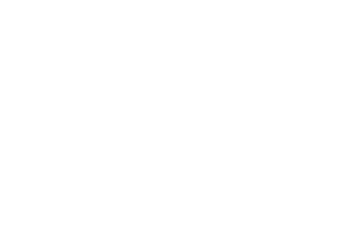


/theartnewspaper_long_text.csv
unique tags count: 76
unique tags count after updating: 76


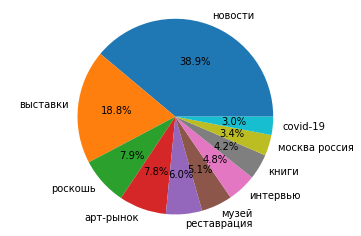


/artchive_long_text.csv
unique tags count: 11949
unique tags count after updating: 11949


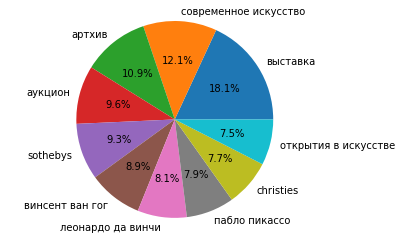


/artuzel_long_text.csv
unique tags count: 607
unique tags count after updating: 607


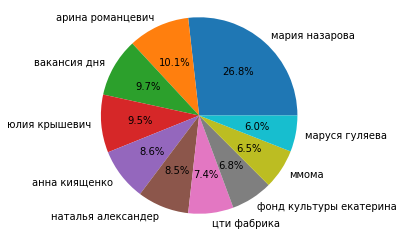

In [ ]:
def by_value(item):
  return item[1]

name_list = list(combo_df_dict.keys())
for name in name_list:
  print(name)
  tags_count_dict = {tag: 0 for tag in total_tags_lists[name_list.index(name)]}
  print('unique tags count:', len(tags_count_dict))

  df = combo_df_dict[name]
  for tags_list in df.loc[df['tags_list_len']>0]['tags_list'].tolist(): # list of lists
    for tag in tags_list:
      tag_count = tags_count_dict[tag] + 1
      tags_count_dict.update({tag: tag_count})
  print('unique tags count after updating:', len(tags_count_dict))
  
  counts = []
  tags = []
  for k, v in sorted(tags_count_dict.items(), key=by_value, reverse=True)[:10]:
    counts.append(v)
    tags.append(k)

  fig, ax = plt.subplots()
  ax.pie(counts[:10], labels=tags[:10], autopct='%1.1f%%')
  ax.axis("equal")
  plt.show()
  print('')

1. **artinvest_news_articles_w_text** doesn't have tags at all
2. **theartnewspaper_w_text** is good for study general categories and location
3. **artchive_news_articles_w_text** is good for study general categories and detales
4. **artuzel_news_articles_w_text**: names are mostly of authors and it's hard to exclude them by eye

In [ ]:
# Pages titles exploration
for name, df in combo_df_dict.items():
  print(name)
  print('Pages titles count', df['page_title'].nunique())
  print(df['page_title'].unique())
  print('')

/artinvest_long_text.csv
Pages titles count 11
['Новости искусства' 'Аукционы произведений искусства'
 'Выставки произведений искусства' 'Рынок искусства: аналитика и прогнозы'
 '21-й век' 'Обзоры событий в мире искусства' 'Рассказы о художниках'
 'Первые имена' 'Инвестиционные идеи на рынке искусства'
 'Экспертиза, реставрация, хранение' 'Интервью']

/theartnewspaper_long_text.csv
Pages titles count 48
['Реставрация' 'Интервью' 'Крупным планом' 'Выставки' 'Новости'
 'Париж Франция' 'Музей будущего' 'Роскошь' 'Москва Россия' 'Арт-рынок'
 'Екатеринбург Россия' 'Назначения' 'Фестивали' 'Спецпроект' 'Cartier'
 'Приглашения' 'Музей' 'Ярмарки' 'Кинофестиваль' 'Некролог' 'COVID-19'
 'Лос-Анджелес США' 'Промо' 'Audi Россия' 'Путешествие'
 'Московская область Россия' 'Мнения' 'Колонка' 'Книги' 'Рим Италия'
 'Антверпен Бельгия' 'Флоренция Италия' 'Календарь' 'NFT' 'Биеннале'
 'Нью-Йорк США' 'Нижний Новгород Россия' 'Великий Новгород Россия'
 'Художники' 'Архитектура' 'США' 'Самара Россия' 'Прем

In [ ]:
for name, df in combo_df_dict.items():
  print(name)
  print('Titles count', df['title'].count())
  print('Titles unique', df['title'].nunique())
  print('Count of repeated titles', df['title'].count() - df['title'].nunique())
  print('')

/artinvest_long_text.csv
Titles count 13310
Titles unique 12848
Count of repeated titles 462

/theartnewspaper_long_text.csv
Titles count 1169
Titles unique 1168
Count of repeated titles 1

/artchive_long_text.csv
Titles count 4043
Titles unique 4041
Count of repeated titles 2

/artuzel_long_text.csv
Titles count 5148
Titles unique 5058
Count of repeated titles 90



In [ ]:
# Look at combo of page_title, tags_list, title and short_text

def sample_tags_analysis(df):
  sample_df = df.sample(20)
  title_list = sample_df['title'].tolist()
  short_text_list = sample_df['short_text'].tolist()
  page_title_list = sample_df['page_title'].tolist()
  tags_list_list = sample_df['tags_list'].tolist()

  for idx, el in enumerate(page_title_list):
    print(el)
    print(tags_list_list[idx])
    print(title_list[idx])
    print(short_text_list[idx])
    print('')

In [ ]:
# artinvest_news_articles_w_text # artuzel_news_articles_w_text
# theartnewspaper_w_text # artchive_news_articles_w_text

sample_tags_analysis(theartnewspaper_w_text)

Книги
['книги']
Модернизм на ленинградский манер: чем интересен и почему достоин сбережения
У коллективной монографии «Ленинград: архитектура советского модернизма. 1955–1991» в качестве обозначения жанра фигурирует термин «справочник-путеводитель». Но в сухости слога это издание не упрекнешь — как и в недостатке колоритных фактов

Выставки
['выставки', 'нью-йорк сша']
KAWS теперь не только мировой бренд, но и музейное искусство
В Бруклинском музее проходит выставка «KAWS. Какая вечеринка!»

Новости
['новости', 'covid-19']
Венецианскую биеннале перенесли из-за коронавируса
XVII Архитектурная биеннале в Венеции, которая должна была начаться 23 мая, перенесена — теперь она должна стартовать 29 августа и продлиться три месяца, до 29 ноября

Новости
['новости', 'милан италия']
Фонд Prada теперь в Милане
Новая площадка Фонда Prada откроется в Милане 9 мая, а предварительный просмотр для профессионалов арт-сообщества начнется уже 2-го

Выставки
['выставки']
Гениев оказалось больше, чем букв 

In [ ]:
# artinvest_news_articles_w_text # artuzel_news_articles_w_text
# theartnewspaper_w_text # artchive_news_articles_w_text

sample_tags_analysis(artchive_news_articles_w_text)
# artchive doesn't have short texts

Новости музеев и галерей
['авангардизм', 'анри де тулуз-лотрек', 'выставка ', 'галерея крокер', 'группа наби', 'импрессионисты', 'модернизм', 'постимпрессионисты', 'символизм']
Анри де Тулуз-Лотрек и парижская жизнь: в Сакраменто открылась выставка серого кардинала Монмартра и его «гвардейцев»
Анри де Тулуз-Лотрек и парижская жизнь: в Сакраменто открылась выставка серого кардинала Монмартра и его «гвардейцев»

Новичкам
['исаак левитан', 'пейзаж']
Волга, Волга. Великая русская река глазами Левитана
Волга, Волга. Великая русская река глазами Левитана

Новости музеев и галерей
['анна валайер-костер', 'анри фантен-латур', 'букеты', 'гюстав кайботт', 'импрессионизм', 'камиль писсарро', 'музеи сша', 'натюрморт', 'поль гоген', 'пьер боннар', 'пьер-жозеф редуте', 'французская живопись', 'цветочный натюрморт', 'эдуард мане']
Американские гастроли французских букетов: выставка цветочных натюрмортов побывает в трех городах
Американские гастроли французских букетов: выставка цветочных натюрмортов 

### Titles
Let's find out if it's possible to clusterize articles using titles

In [15]:
import string

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords, words

! pip install pymorphy2
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 8.2 MB 11.4 MB/s 


In [33]:
stop_words_r = stopwords.words('russian')
print(len(stop_words_r))
stop_words_e = stopwords.words('english')
print(len(stop_words_e))

151

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We'll use only word and will tokenize titles by words.

In [16]:
stemmer = SnowballStemmer(language='english') # for english words
#stemmer = PorterStemmer() # for english words
morph = pymorphy2.MorphAnalyzer() # for russian words
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def final_cleaning(text):
  text = text.lower()
  ## letters = re.findall('[a-ZA-Z\s]', text)# non-English characters
  ## text = ''.join(letters)
  text = re.sub('\[.*?\]', '', text) # brackets
  text = re.sub('\w*\d\w*', '', text) # numbers
  text = re.sub('[‘’“”«»''""“”„“…№]', '', text) # upper punctuation
  text = re.sub(' — | – |-', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #punctuation
  #text = re.sub('[!#$%&()*+,.:;<=>?@^_`{|}~]', '', text) # punctuation

  return text


def get_sent_tokens(text):
  tokens = sent_tokenize(text, language='russian')
  return tokens


def get_word_tokens(text):

  tokens = word_tokenize(text, language='russian')
  
  tokens=[morph.parse(w)[0].normal_form if w not in english_vocab else w for w in tokens]
  #tokens=[stemmer.stem(w) if w in english_vocab else w for w in tokens]
  tokens = [w for w in tokens if w not in stopwords.words('russian') and not in stopwords.words('english') and len(w) > 1]
    
  return tokens

In [70]:
start_t = time.time()
for df in combo_df_dict.values():
  df['title_new'] = df['title'].dropna().apply(final_cleaning).apply(get_word_tokens)
  #df['title_new'] = df['title'].dropna().apply(get_sent_tokens) # .!? without blanck space - ?
print('{} seconds have passed'.format(time.time() - start_t))

79.76906037330627 seconds have passed


In [66]:
# Look at some samples
for name, df in combo_df_dict.items():
  print(name)
  print('')
  
  sample_df = df.sample(20)
  title_list = sample_df['title'].tolist()
  title_new_list = sample_df['title_new'].tolist()

  for idx, el in enumerate(title_list):
    print(el)
    print(title_new_list[idx])
    print('')

/artinvest_long_text.csv

Кроссовки Канье Уэста купили за рекордные $1,8 миллиона
['кроссовок', 'канье', 'уэст', 'купить', 'рекордный', 'миллион']

В 2021 году лишь 11 % всех галерей торговали NFT-искусством
['год', 'лишь', 'весь', 'галерея', 'торговать', 'nftискусство']

Открыт 69-й аукцион «XXI век. Современное российское искусство»
['открыть', 'аукцион', 'xxi', 'век', 'современный', 'российский', 'искусство']

Сотни фильмов Энди Уорхола оцифруют
['сотня', 'фильм', 'энди', 'уорхол', 'оцифровать']

Галерея 2. 36 представляет «Скромное обаяние...»
['галерея', 'представлять', 'скромный', 'обаяние']

Дом с фреской Бэнкси выставлен на продажу
['дом', 'фреска', 'бэнксить', 'выставить', 'продажа']

«Анатолий Брусиловский. Пантеон русского андеграунда»
['анатолий', 'брусиловский', 'пантеон', 'русский', 'андеграунд']

Опубликованы индикаторы инвестиционного риска для торгов Heritage Auction 14 ноября 2008 года
['опубликовать', 'индикатор', 'инвестиционный', 'риск', 'торг', 'heritage', 'auctio

#### library

In [47]:
import collections
import statistics as s

In [48]:
! pip install -U gensim
from gensim.models import Word2Vec

from sklearn.manifold import TSNE

     |████████████████████████████████| 24.1 MB 51.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [49]:
# A naive approach to creating a single embedding for a document is an average embedding by words

def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
      try:
        if num_words == 0:
          doc_vector = model.wv[word]
        else:
          doc_vector = np.add(doc_vector, model.wv[word])
        num_words += 1
      except:
        pass
     
    return np.asarray(doc_vector)/num_words

In [50]:
''' Hopkins' statistic for searching a tendency to group data

https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb'''

#importing the required libraries
from sklearn.neighbors import NearestNeighbors
from numpy.random import uniform

# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    #X = X.values  #convert dataframe to a numpy array - already a numpy array !
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0), (sample_size, X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices = sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances, u_indices = nbrs.kneighbors(X_uniform_random_sample, n_neighbors=2)
    u_distances = u_distances[:, 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances, w_indices = nbrs.kneighbors(X_sample, n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[:, 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    
    return H

#### all w_text dfs
Create a singal df with redused number of columns and get rid of articles without tokenized title

In [72]:
for name in combo_df_dict.keys():
  print(name, '->', name.split('_')[0][1:])

/artinvest_long_text.csv -> artinvest
/theartnewspaper_long_text.csv -> theartnewspaper
/artchive_long_text.csv -> artchive
/artuzel_long_text.csv -> artuzel


In [123]:
'''
['date', 'link', 'title', 'short_text', 'page_url', 'page_title',
 'long_text_url', 'parsing_date', 'parsing_time', 'parsing_sec_speed',
 'long_text', 'structure', 'images', 'sourses', 'tags',
 'parsing_sec_speed_2', 'news_article_cat', 'tags_list', 'tags_list_len',
 'title_new', 'df_name']
 '''

In [71]:
df_name_list = []
df_title_new_list = []
df_tags_list_list = []
df_page_title_list = []

for name, df in combo_df_dict.items():
  df['df_name'] = name.split('_')[0][1:]
  df_name_list.extend(df['df_name'].tolist())
  df_title_new_list.extend(df['title_new'].tolist())
  df_tags_list_list.extend(df['tags_list'].tolist())
  df_page_title_list.extend(df['page_title'].tolist())

df_title_len_list = [len(x) for x in df_title_new_list]
print(len(df_name_list), len(df_title_new_list), len(df_title_len_list))
print('')

df_titles = pd.DataFrame({'df_name': df_name_list, 'page_title': df_page_title_list, 
                          'title_new': df_title_new_list, 'tags_list': df_tags_list_list, 
                          'title_len': df_title_len_list})
df_titles.info()

23670 23670 23670

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23670 entries, 0 to 23669
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   df_name     23670 non-null  object
 1   page_title  23670 non-null  object
 2   title_new   23670 non-null  object
 3   tags_list   23670 non-null  object
 4   title_len   23670 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 924.7+ KB


In [72]:
df_titles.describe()

,title_len
count,23670.000000
mean,6.166117
std,2.411848
min,0.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,22.000000


In [73]:
df_titles = df_titles.loc[df_titles['title_len']>0]
df_titles.describe()

,title_len
count,23658.000000
mean,6.169245
std,2.408457
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,22.000000


In [74]:
# Words exploration: unique words and their frequency
words_dict = collections.Counter() # {word: its frequency}

for line in df_titles['title_new'].tolist():
  for word in line:
    words_dict[word] += 1

print(type(words_dict))
print(len(words_dict))

<class 'collections.Counter'>
18290


In [79]:
print('Count of unique words:', len(words_dict))
print('Minimum of unique words count:', min([v for v in words_dict.values()]))
print('Maximum of unique words count:', max([v for v in words_dict.values()]))
print('Average of unique words count:', int(round(s.mean([v for v in words_dict.values()]), 0)))
print('Median of unique words count:', int(round(s.median([v for v in words_dict.values()]), 0)))
print('Mode of unique words count:', s.mode([v for v in words_dict.values()]))
print('Quantiles of unique words count:', [int(round(q, 0)) for q in np.percentile([v for v in words_dict.values()], [25, 50, 75])])

Count of unique words: 18905
Minimum of unique words count: 1
Maximum of unique words count: 2561
Average of unique words count: 8
Median of unique words count: 1
Mode of unique words count: 1
Quantiles of unique words count: [1, 1, 4]


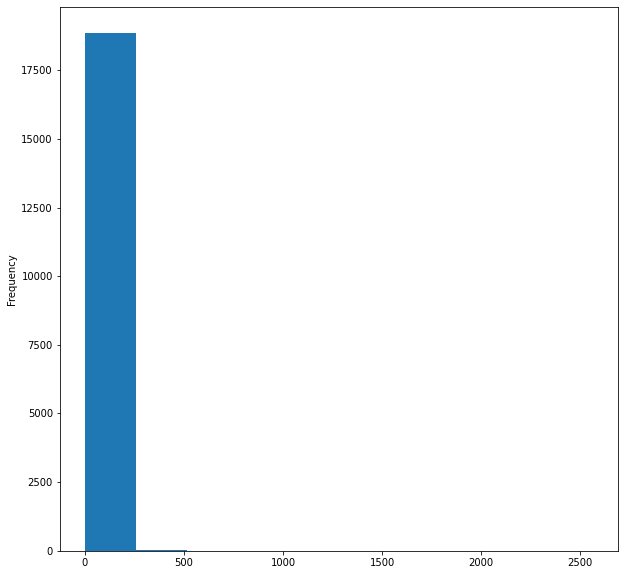

In [80]:
pd.Series([v for v in words_dict.values()]).plot(kind = 'hist')

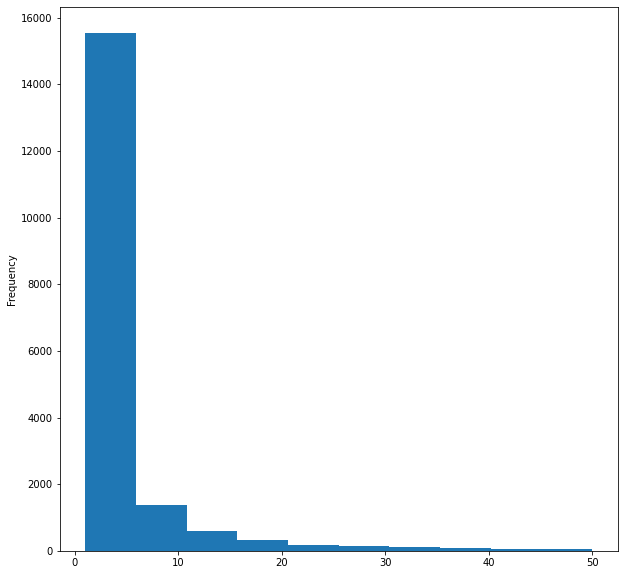

In [85]:
pd.Series([v for v in words_dict.values() if v <= 50]).plot(kind = 'hist')

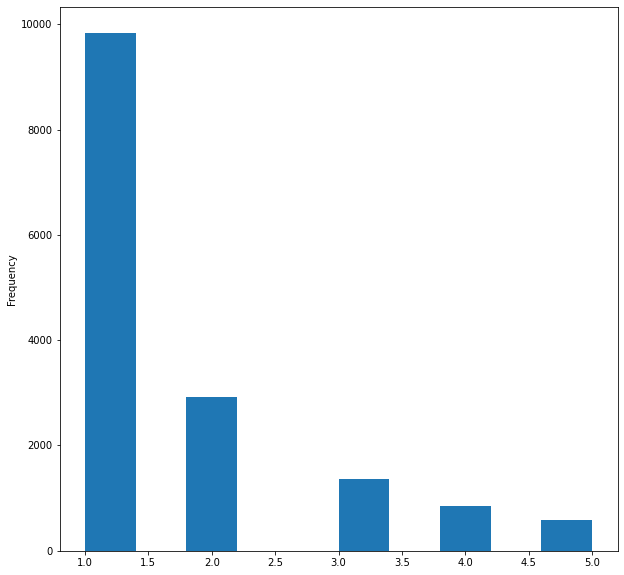

In [84]:
pd.Series([v for v in words_dict.values() if v <= 5]).plot(kind = 'hist')

Let's move on to text vectorization: each word will be encoded with 50 numbers. We will also make an average vector for all words, so we get a vector for the text as a whole.

We have 18905 unique words in the corpus. There're some words that occur 2561 times but mostly words occur just once (!). We also know that average length of title is 6 words.

So we can't limit creating of vectors with min_count (for example, for those words that occur more than 20 times in all texts of documents) - we'll loose a lot of titles then.

In [79]:
docs = df_titles['title_new'].tolist()
model = Word2Vec(docs, min_count=1, vector_size=50)

# Make embedding for our documents
X_titles = []
for doc in docs:
  X_titles.append(doc_vectorizer(doc, model))

# Check the size of documents' vector
print(np.asarray(X_titles).shape)

X_titles[:2]

(23658, 50)


[array([ 0.28846005,  0.19848543,  0.08467358,  0.48166028, -0.13798629,
        -0.0370759 ,  0.5943318 ,  0.43538228, -0.6737222 , -0.00215316,
         0.04478241, -0.25024524,  0.31547534,  0.32944646,  0.1649872 ,
         0.01246001,  0.44272694,  0.12957859, -0.4136386 , -0.45003402,
         0.04519539,  0.3579189 ,  0.5226199 , -0.2638476 ,  0.14949287,
        -0.04282334, -0.24622457,  0.22702135, -0.16489089, -0.3278967 ,
        -0.17077255, -0.35630688,  0.38753137,  0.01946071, -0.22737765,
         0.17639196,  0.18910718,  0.33275133, -0.10539758, -0.39606062,
         0.40352654,  0.16127746,  0.08346183,  0.06030765,  0.325068  ,
        -0.01996863,  0.0908798 , -0.0371861 , -0.18450105,  0.38468316],
       dtype=float32),
 array([ 0.80156684,  0.47166115,  0.2934799 ,  1.0511055 , -0.3477345 ,
         0.09442988,  1.1689394 ,  1.0126119 , -1.2080623 , -0.11159682,
        -0.1573223 , -0.22912948,  0.4353483 ,  0.36999828,  0.37146324,
        -0.18366772,  0.701

In [80]:
# Creating an object to execute t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Transform our data by reducing the dimension from 50 to 2
X_titles = tsne.fit_transform(X_titles)

print(np.asarray(X_titles).shape)
X_titles[:3]

(23658, 2)


array([[-23.817688 , -29.436533 ],
       [ -0.9315243, -47.299355 ],
       [ 57.983505 ,  -9.182289 ]], dtype=float32)

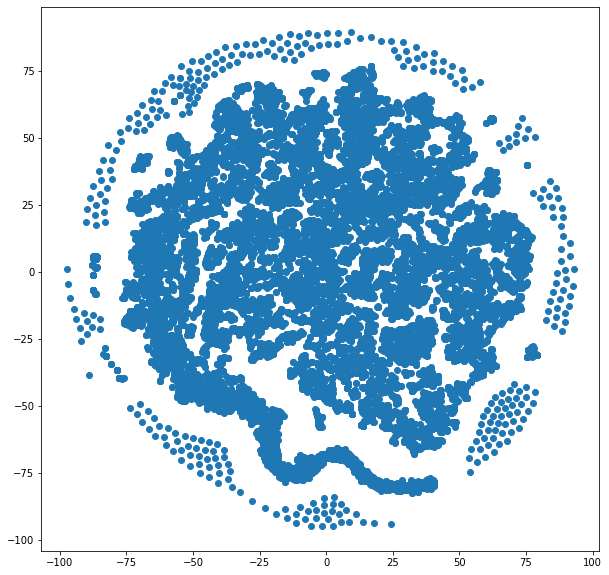

In [82]:
# X distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_titles[:, 0], X_titles[:, 1]) #, s=200, alpha=.5
plt.show()

Well, if it's really wanted, it's possible to see both ribbon structures and many groups with a center here. So maybe, ***agglomerative clustering*** could help. But do these groups relate to anuthing real?

Let's take articles' categories (['page_title']) as a target for the beginning.

In [81]:
# Creating of colors for target variable
Y_titles = df_titles['page_title'].tolist()

page_title_list = df_titles['page_title'].unique()
colors_list = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(len(page_title_list))]
colors_dict = {k: v for k, v in zip(page_title_list, colors_list)}

y_titles = [colors_dict[c] for c in Y_titles]
y_titles[:3]

['#8BF5EC', '#41FB24', '#EAE8CB']

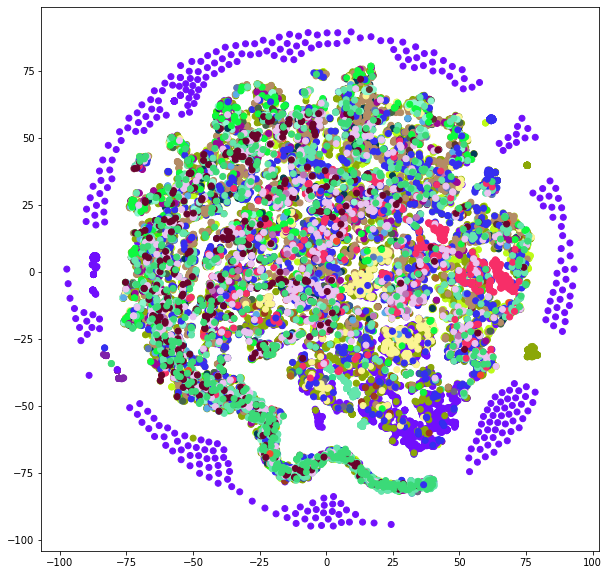

In [83]:
# X and Y distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_titles[:, 0], X_titles[:, 1], c=y) #, s=200, alpha=.5
plt.show()

It doesn't seem that we have a tendency to group data. With the exception of the rim, which doesn't exhaust the group, but excludes the rest.

In [84]:
# call the function on the iris dataset
H = hopkins_statistic(X_titles)
print(H)

''' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects 
are distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'''

0.949917044796306


' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects \nare distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'

### Short text
Let's find out if it's possible to clusterize articles using short texts.

We'll use only word and will tokenize short texts by words.

In [85]:
start_t = time.time()
for df in combo_df_dict.values():
  df['short_text_new'] = df['short_text'].dropna().apply(final_cleaning).apply(get_word_tokens)
  #df['short_text_new'] = df['short_text'].dropna().apply(get_sent_tokens) # .!? without blanck space - ?
print('{} seconds have passed'.format(time.time() - start_t))

212.50689959526062 seconds have passed


In [97]:
for name, df in combo_df_dict.items():
  print(name)
  print('')
  
  sample_df = df.sample(10)
  short_text_list = sample_df['short_text'].tolist()
  short_text_new_list = sample_df['short_text_new'].tolist()

  for idx, el in enumerate(short_text_list):
    print(el)
    print(short_text_new_list[idx])
    print('')

/artinvest_long_text.csv

В экспозиции можно увидеть зубастых мышей, гримасничающие цветы, Овального Будду и прочие чудеса
['экспозиция', 'увидеть', 'зубастый', 'мышь', 'гримасничать', 'цветок', 'овальный', 'будда', 'прочий', 'чудо']

ARTinvestment. RU представляет документальные фильмы и передачи об изобразительном искусстве, которые можно будет посмотреть на телеканале «Россия К» («Культура») на следующей неделе
['artinvestment', 'ru', 'представлять', 'документальный', 'фильм', 'передача', 'изобразительный', 'искусство', 'который', 'посмотреть', 'телеканал', 'россия', 'культура', 'следующий', 'неделя']

Открыты 35-е торги электронной торговой площадки «AI Аукцион»
['открыть', 'торг', 'электронный', 'торговый', 'площадка', 'ai', 'аукцион']

Сегодня в Государственной Третьяковской галерее открывается выставка ведущего современного скульптора Финляндии Кари Хухтамо
['сегодня', 'государственный', 'третьяковский', 'галерея', 'открываться', 'выставка', 'ведущий', 'современный', 'скульптор'

#### all w_text dfs
Create a singal df with redused number of columns and get rid of articles without tokenized short text

In [ ]:
for name in combo_df_dict.keys():
  print(name, '->', name.split('_')[0][1:])

/artinvest_long_text.csv -> artinvest
/theartnewspaper_long_text.csv -> theartnewspaper
/artchive_long_text.csv -> artchive
/artuzel_long_text.csv -> artuzel


In [ ]:
theartnewspaper_w_text.columns

Index(['date', 'link', 'title', 'short_text', 'page_url', 'page_title',
       'long_text_url', 'parsing_date', 'parsing_time', 'parsing_sec_speed',
       'long_text', 'structure', 'images', 'sourses', 'tags',
       'parsing_sec_speed_2', 'news_article_cat', 'tags_list', 'tags_list_len',
       'title_new', 'df_name'],
      dtype='object')

In [86]:
df_name_list = []
df_short_text_new_list = []
df_tags_list_list = []
df_page_title_list = []

for name, df in combo_df_dict.items():
  df['df_name'] = name.split('_')[0][1:]
  df_name_list.extend(df['df_name'].tolist())
  df_short_text_new_list.extend(df['short_text_new'].tolist())
  df_tags_list_list.extend(df['tags_list'].tolist())
  df_page_title_list.extend(df['page_title'].tolist())

df_short_text_len_list = [len(x) for x in df_short_text_new_list]

df_short_text = pd.DataFrame({'df_name': df_name_list, 'page_title': df_page_title_list, 
                          'short_text_new': df_short_text_new_list, 'tags_list': df_tags_list_list, 
                          'short_text_len': df_short_text_len_list})
df_short_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23670 entries, 0 to 23669
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   df_name         23670 non-null  object
 1   page_title      23670 non-null  object
 2   short_text_new  23670 non-null  object
 3   tags_list       23670 non-null  object
 4   short_text_len  23670 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 924.7+ KB


In [87]:
df_short_text.describe()

,short_text_len
count,23670.000000
mean,16.245289
std,7.028391
min,0.000000
25%,10.000000
50%,16.000000
75%,23.000000
max,73.000000


In [88]:
df_short_text = df_short_text.loc[df_short_text['short_text_len']>0]
#df_short_text = df_short_text.loc[(df_short_text['short_text_len']>0)&(df_short_text['df_name']!='artchive')]
df_short_text.describe()

,short_text_len
count,23669.000000
mean,16.245976
std,7.027746
min,1.000000
25%,10.000000
50%,16.000000
75%,23.000000
max,73.000000


In [110]:
# Words exploration: unique words and their frequency
words_dict = collections.Counter() # {word: its frequency}

for line in df_short_text['short_text_new'].tolist():
  for word in line:
    words_dict[word] += 1

print(type(words_dict))
print(len(words_dict))

<class 'collections.Counter'>
31390


In [111]:
print('Count of unique words:', len(words_dict))
print('Minimum of unique words count:', min([v for v in words_dict.values()]))
print('Maximum of unique words count:', max([v for v in words_dict.values()]))
print('Average of unique words count:', int(round(s.mean([v for v in words_dict.values()]), 0)))
print('Median of unique words count:', int(round(s.median([v for v in words_dict.values()]), 0)))
print('Mode of unique words count:', s.mode([v for v in words_dict.values()]))
print('Quantiles of unique words count:', [int(round(q, 0)) for q in np.percentile([v for v in words_dict.values()], [25, 50, 75])])

Count of unique words: 31390
Minimum of unique words count: 1
Maximum of unique words count: 6854
Average of unique words count: 12
Median of unique words count: 2
Mode of unique words count: 1
Quantiles of unique words count: [1, 2, 4]


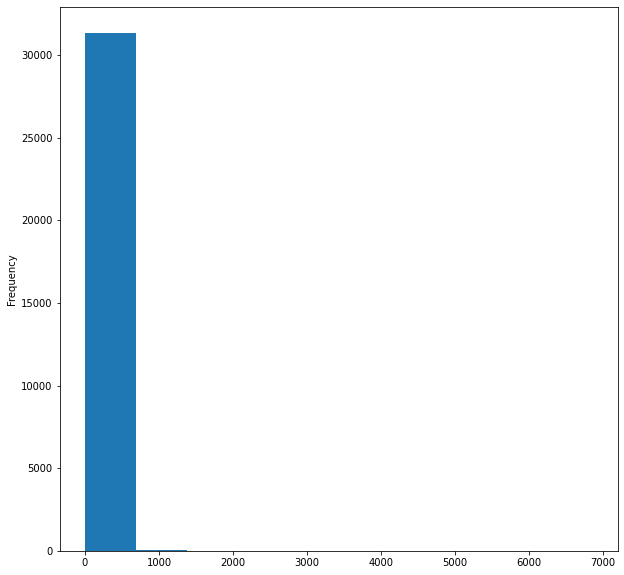

In [112]:
pd.Series([v for v in words_dict.values()]).plot(kind = 'hist')

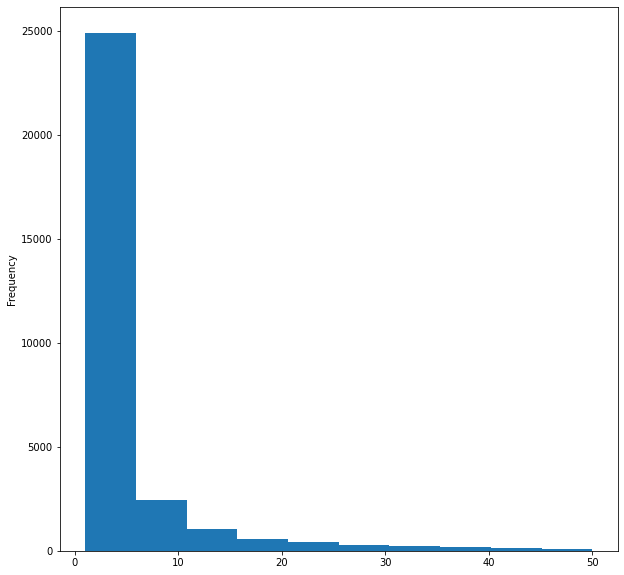

In [113]:
pd.Series([v for v in words_dict.values() if v <= 50]).plot(kind = 'hist')

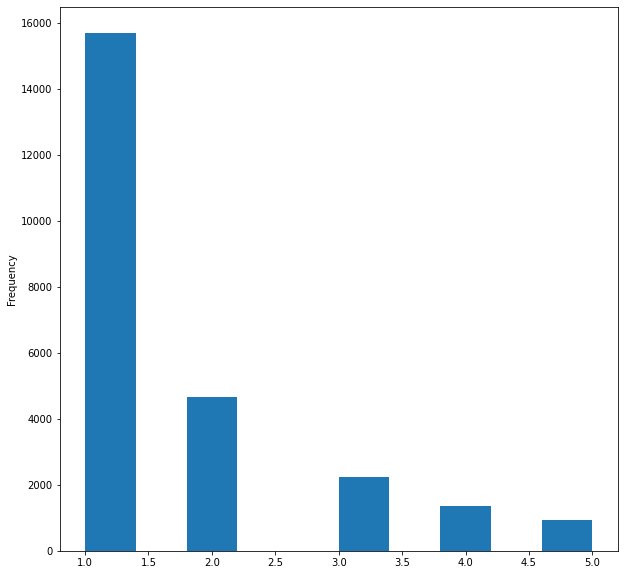

In [114]:
pd.Series([v for v in words_dict.values() if v <= 5]).plot(kind = 'hist')

Let's move on to text vectorization: each word will be encoded with 50 numbers. We will also make an average vector for all words, so we get a vector for the text as a whole.

We have 31390 unique words in the corpus. There're some words that occur 6854 times but still words mostly occur just once (!). We also know that average length of text is 16 words.

So we can't limit creating of vectors with min_count (for example, for those words that occur more than 20 times in all texts of documents) - we'll loose a lot of texts then.

In [89]:
docs = df_short_text['short_text_new'].tolist()
model = Word2Vec(docs, min_count=1, vector_size=50)

# Make embedding for our documents
X_short = []
for doc in docs:
  X_short.append(doc_vectorizer(doc, model))

# Check the size of documents' vector
print(np.asarray(X_short).shape)

X_short[:2]

(23669, 50)


[array([-0.22030574, -0.43610966, -0.29974008, -0.07044203, -0.26057872,
        -0.72208834, -0.15220143,  0.95399874, -0.443284  , -0.44899547,
        -0.15192597, -0.76729864,  0.29264078,  0.63981575, -0.53094596,
         0.01303784,  0.3886286 ,  0.04749972, -0.46486583, -0.3725346 ,
        -0.24218404,  0.31338015,  0.41798612, -0.05022099, -0.02990147,
        -0.08328054, -0.12676547, -0.00581888, -0.3233967 ,  0.4221398 ,
         0.34023905,  0.06204795,  0.19588475, -0.01343568, -0.4068712 ,
         0.00883918,  0.4012431 , -0.05190322,  0.08159467, -0.16254334,
         0.89197904, -0.01053426,  0.10850358, -0.06310403,  0.8354675 ,
        -0.01233615, -0.22183877, -0.02434295, -0.03604154,  0.16272473],
       dtype=float32),
 array([-8.1994867e-01, -6.9170171e-01, -5.3741682e-01,  9.0481859e-01,
        -5.3251886e-01, -1.1755856e+00,  3.4587687e-01,  1.3408748e+00,
        -8.2042110e-01, -7.3713350e-01,  6.0954183e-01, -1.5021428e+00,
         3.3416021e-01,  1.100

In [90]:
# Creating an object to execute t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Transform our data by reducing the dimension from 50 to 2
X_short = tsne.fit_transform(X_short)

print(np.asarray(X_short).shape)
X_short[:3]

(23669, 2)


array([[-50.361813 ,   1.0359399],
       [ 28.679668 ,  51.341965 ],
       [-10.429311 ,   9.118263 ]], dtype=float32)

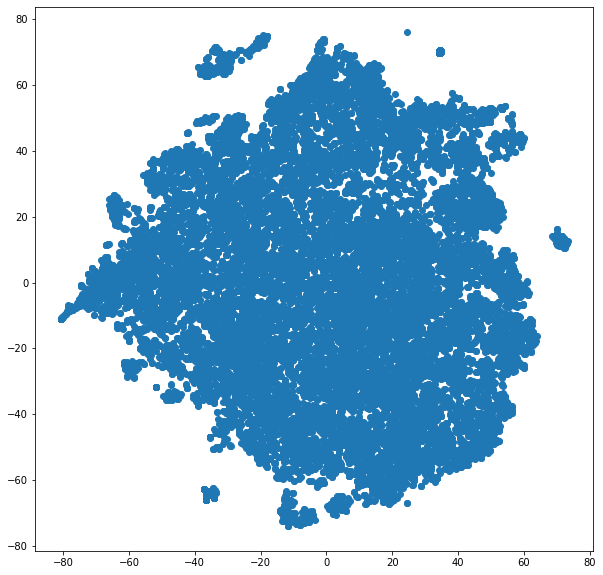

In [92]:
# X distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_short[:, 0], X_short[:, 1]) #, s=200, alpha=.5
plt.show()

In [91]:
# Creating of colors for target variable
# Let's take articles' categories (['page_title']) as a target for the beginning.

Y_short = df_short_text['page_title'].tolist()

page_title_list = df_short_text['page_title'].unique()
colors_list = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(len(page_title_list))]
colors_dict = {k: v for k, v in zip(page_title_list, colors_list)}

y_short = [colors_dict[c] for c in Y_short]
y_short[:3]

['#3FD85C', '#A22374', '#27F803']

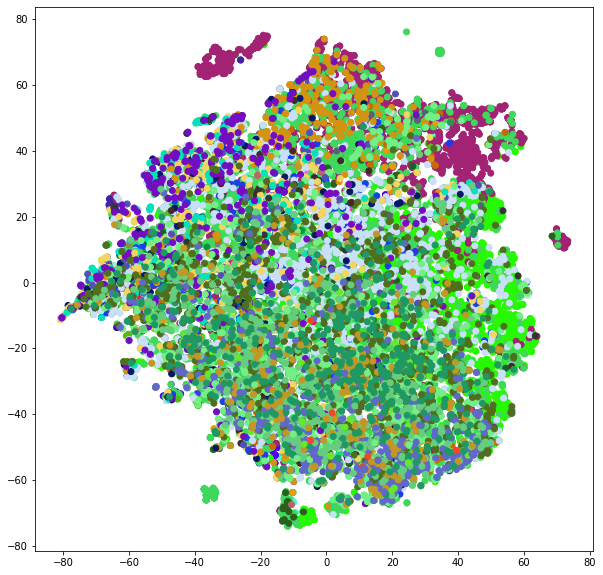

In [93]:
# X and Y distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_short[:, 0], X_short[:, 1], c=y_short) #, s=200, alpha=.5
plt.show()

It's very hard to find a tendency to group data here. In some parts of one large spot, you can see the predominance of individual colors, but the dots are sparse, so in general it's just a mess.

And Hopkins statistics agree with me.

In [94]:
# call the function on the iris dataset
H = hopkins_statistic(X_short)
print(H)

''' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects 
are distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'''

0.952300757936379


' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects \nare distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'

### Long text
Let's find out if it's possible to clusterize articles using long texts

We'll use only word and will tokenize texts by words.

In [95]:
start_t = time.time()
for df in combo_df_dict.values():
  df['long_text_new'] = df['long_text'].dropna().apply(lambda x: ' '.join(x))
  df['long_text_new'] = df['long_text_new'].dropna().apply(final_cleaning).apply(get_word_tokens)
  #df['long_text_new'] = df['long_text'].dropna().apply(get_sent_tokens) # .!? without blanck space - ?
print('{} seconds have passed'.format(time.time() - start_t))

5289.417862176895 seconds have passed


In [25]:
for name, df in combo_df_dict.items():
  print(name)
  print('')
  
  sample_df = df.sample(5)
  long_text_list = sample_df['long_text'].tolist()
  long_text_new_list = sample_df['long_text_new'].tolist()

  for idx, el in enumerate(long_text_list):
    print(el)
    print(long_text_new_list[idx])
    print('')

/artinvest_long_text.csv

['Статистика AI Аукциона № 253. Продано 45 % лотов.', 'Тем, кто пропустил объявление в прошлый раз, напомним, что результаты торгов мы теперь публикуем в обобщенном виде, без прежней разбивки по ценам за каждый лот. Почувствовать настроение рынка информации хватит, но за деталями теперь остается следить лишь в реальном времени.', 'В этот раз мы продали 45 % нашего каталога. Максимальная выигрышная ставка составила 600000 рублей, а самый доступный лот купили за 9000 рублей.', 'Всем — спасибо и хороших выходных! В следующий раз у нас будут шикарный Андрей Гросицкий, этюд Константина Савицкого, графика Александра Бенуа, акварель Николая Вечтомова, живопись Юрия Купера, скульптуры Владимира Немухина и Владимира Янкилевского, картина Игоря Снегура, папка с литографиями Михаила Шемякина, акварель Анатолия Зверева, масло Ильи Табенкина и другие интересные лоты.', 'До встречи в понедельник.', 'Ваш AI Аукциион.', '***.', 'Мы продолжаем принимать живопись и графику (ори

#### all w_text dfs
Create a singal df with redused number of columns and get rid of articles without tokenized long text

In [ ]:
for name in combo_df_dict.keys():
  print(name, '->', name.split('_')[0][1:])

/artinvest_long_text.csv -> artinvest
/theartnewspaper_long_text.csv -> theartnewspaper
/artchive_long_text.csv -> artchive
/artuzel_long_text.csv -> artuzel


In [ ]:
''' 
['date', 'link', 'title', 'short_text', 'page_url', 'page_title',
 'long_text_url', 'parsing_date', 'parsing_time', 'parsing_sec_speed',
 'long_text', 'structure', 'images', 'sourses', 'tags',
 'parsing_sec_speed_2', 'news_article_cat', 'tags_list', 'tags_list_len',
 'title_new', 'df_name']
 '''

Index(['date', 'link', 'title', 'short_text', 'page_url', 'page_title',
       'long_text_url', 'parsing_date', 'parsing_time', 'parsing_sec_speed',
       'long_text', 'structure', 'images', 'sourses', 'tags',
       'parsing_sec_speed_2', 'news_article_cat', 'tags_list', 'tags_list_len',
       'title_new', 'df_name'],
      dtype='object')

In [96]:
df_name_list = []
df_long_text_list = []
df_long_text_new_list = []
df_tags_list_list = []
df_page_title_list = []

for name, df in combo_df_dict.items():
  df['df_name'] = name.split('_')[0][1:]
  df_name_list.extend(df['df_name'].tolist())
  df_long_text_list.extend(df['long_text'].tolist())
  df_long_text_new_list.extend(df['long_text_new'].tolist())
  df_tags_list_list.extend(df['tags_list'].tolist())
  df_page_title_list.extend(df['page_title'].tolist())

df_long_text_len_list = [len(x) for x in df_long_text_new_list]

df_long_text = pd.DataFrame({'df_name': df_name_list, 'page_title': df_page_title_list, 
                             'long_text_new': df_long_text_new_list, 'long_text': df_long_text_list, 
                             'long_text_len': df_long_text_len_list, 'tags_list': df_tags_list_list})
df_long_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23670 entries, 0 to 23669
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   df_name        23670 non-null  object
 1   page_title     23670 non-null  object
 2   long_text_new  23670 non-null  object
 3   long_text      23670 non-null  object
 4   long_text_len  23670 non-null  int64 
 5   tags_list      23670 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [97]:
df_long_text.describe()

,long_text_len
count,23670.000000
mean,402.215632
std,454.028545
min,2.000000
25%,168.000000
50%,272.000000
75%,462.000000
max,8234.000000


In [98]:
df_long_text.loc[df_long_text['long_text_len']<20].describe()

,long_text_len
count,104.000000
mean,10.144231
std,5.849933
min,2.000000
25%,5.000000
50%,7.000000
75%,16.000000
max,19.000000


In [99]:
df_long_text = df_long_text.loc[df_long_text['long_text_len']>=20]
#df_long_text = df_long_text.loc[(df_long_text['long_text_len']>0)&(df_long_text['df_name']!='artchive')]
df_long_text.describe()

,long_text_len
count,23566.000000
mean,403.945897
std,454.279794
min,20.000000
25%,169.000000
50%,274.000000
75%,463.000000
max,8234.000000


In [51]:
# Words exploration: unique words and their frequency
words_dict = collections.Counter() # {word: its frequency}

for line in df_long_text['long_text_new'].tolist():
  for word in line:
    words_dict[word] += 1

print(type(words_dict))
print(len(words_dict))

<class 'collections.Counter'>
177098


In [52]:
print('Count of unique words:', len(words_dict))
print('Minimum of unique words count:', min([v for v in words_dict.values()]))
print('Maximum of unique words count:', max([v for v in words_dict.values()]))
print('Average of unique words count:', int(round(s.mean([v for v in words_dict.values()]), 0)))
print('Median of unique words count:', int(round(s.median([v for v in words_dict.values()]), 0)))
print('Mode of unique words count:', s.mode([v for v in words_dict.values()]))
print('Quantiles of unique words count:', [int(round(q, 0)) for q in np.percentile([v for v in words_dict.values()], [25, 50, 75])])

Count of unique words: 177098
Minimum of unique words count: 1
Maximum of unique words count: 110622
Average of unique words count: 54
Median of unique words count: 2
Mode of unique words count: 1
Quantiles of unique words count: [1, 2, 7]


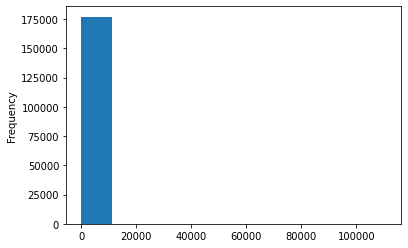

In [53]:
pd.Series([v for v in words_dict.values()]).plot(kind = 'hist')

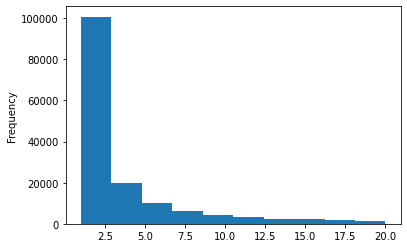

In [57]:
pd.Series([v for v in words_dict.values() if v <= 20]).plot(kind = 'hist')

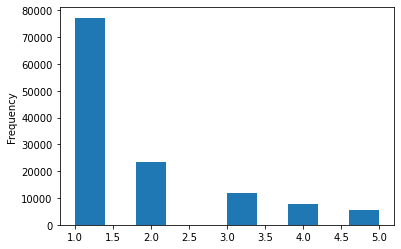

In [58]:
pd.Series([v for v in words_dict.values() if v <= 5]).plot(kind = 'hist')

Let's move on to text vectorization: each word will be encoded with 50 numbers. We will also make an average vector for all words, so we get a vector for the text as a whole.

We have 177098 unique words in the corpus. There're some words that occur 110622 times but still words mostly occur just once (!) despite the fact that all texts with length less then 20 words were deleted. So now, the average length of texts is 404 words.

Anyway, we'll create vectors only for those words that occur more than 20 times in all texts.

In [100]:
docs = df_long_text['long_text_new'].tolist()
model = Word2Vec(docs, min_count=20, vector_size=50)

# Make embedding for our documents
X_long = []
for doc in docs:
  X_long.append(doc_vectorizer(doc, model))

# Check the size of documents' vector
print(np.asarray(X_long).shape)

X_long[:2]

(23566, 50)


[array([ 0.42400786, -0.41012627,  0.08489377, -0.3425513 ,  0.05022211,
        -0.32893655, -0.23123115,  0.6433535 ,  0.03029996, -0.19025062,
         0.9198055 , -0.36603513,  0.7021808 ,  0.2843374 ,  0.08994914,
        -0.5838423 ,  0.2950221 ,  0.82360905,  0.02170588, -0.06575383,
         0.12415123, -0.3266758 , -0.6943863 ,  0.2281571 , -1.5403686 ,
        -0.37444597,  0.2798761 ,  0.34689555,  1.2223436 ,  0.22676836,
        -0.1974775 , -0.41585532, -0.30603665, -0.25400406, -0.5081336 ,
         0.20753306, -0.8197082 , -0.00570743, -0.8807699 , -0.24485153,
        -0.2720673 ,  0.39992917,  0.08171344,  0.13320436, -1.2096016 ,
        -0.49554193,  0.7196    , -0.35181987, -0.64548486,  0.7702892 ],
       dtype=float32),
 array([-0.29583535,  0.1606543 ,  0.06910466, -0.09093939, -0.2076626 ,
        -0.6762881 , -0.76184815,  0.40924177, -0.50996155, -1.0675709 ,
         0.9349147 ,  0.22028643,  1.2295735 ,  0.01684247,  0.01452939,
        -0.5642686 ,  0.051

In [101]:
# Creating an object to execute t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Transform our data by reducing the dimension from 50 to 2
X_long = tsne.fit_transform(X_long)

print(np.asarray(X_long).shape)
X_long[:3]

(23566, 2)


array([[ 35.796547,  26.473051],
       [ 22.788683,  52.863335],
       [-14.98664 ,  26.893948]], dtype=float32)

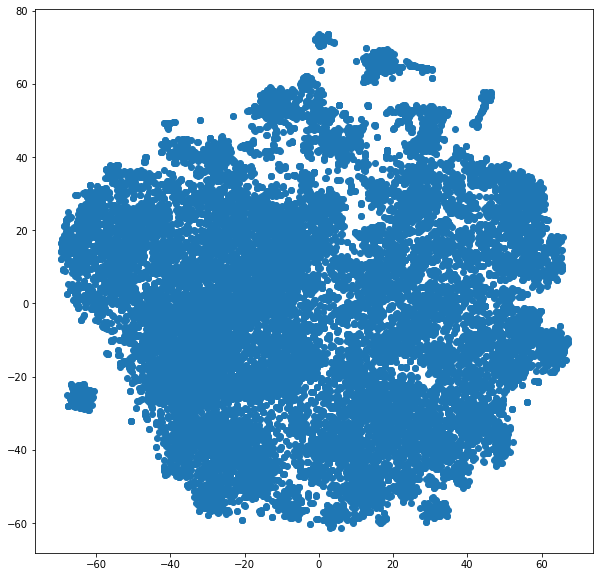

In [103]:
# X distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_long[:, 0], X_long[:, 1]) #, s=200, alpha=.5
plt.show()

In [102]:
# Creating of colors for target variable
# Let's take articles' categories (['page_title']) as a target for the beginning.

Y_long = df_long_text['page_title'].tolist()

page_title_list = df_long_text['page_title'].unique()
colors_list = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(len(page_title_list))]
colors_dict = {k: v for k, v in zip(page_title_list, colors_list)}

y_long = [colors_dict[c] for c in Y_long]
y_long[:3]

['#8D70FF', '#B8F82C', '#3F7DE1']

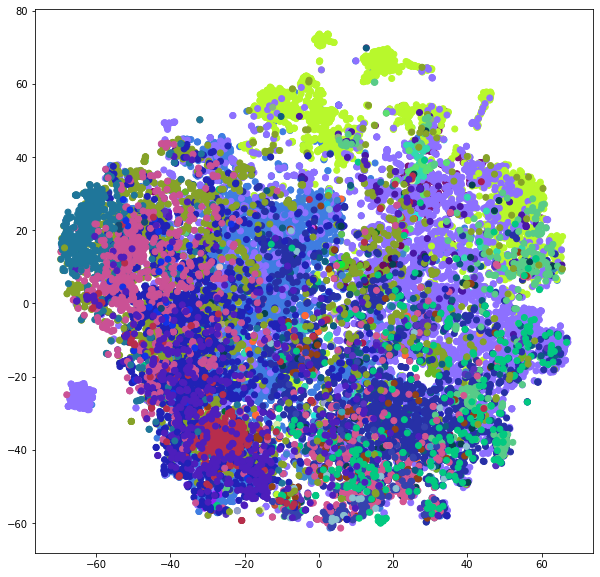

In [104]:
# X and Y distribution on the coordinate plane
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X_long[:, 0], X_long[:, 1], c=y_long) #, s=200, alpha=.5
plt.show()

The same story. It's very hard to find a tendency to group data here. Maybe several big groups without strict edges. In some parts of one large spot, you can see the predominance of individual colors, but the dots are sparse, so in general it's just a mess.

In [105]:
# call the function on the iris dataset
H = hopkins_statistic(X_long)
print(H)

''' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects 
are distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'''

0.9311249504610679


' Hopkins statistics exceeding 0.5 will correspond to the null hypothesis that the grouped objects \nare distributed randomly and uniformly. The statistic value < 0.25 indicates a tendency to group data.'

## ...

In [ ]:
save_df_file(theartnewspaper_w_text, theartnewspaper_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artuzel_news_articles_w_text, artuzel_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artchive_news_articles_w_text, artchive_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artinvest_news_articles_w_text, artinvest_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')